In [19]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import logging
import gc

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Layer, Reshape, InputLayer
import tqdm.notebook as tq

In [5]:
from alibi_detect.models.tensorflow.losses import elbo
from alibi_detect.od import OutlierVAE, OutlierAE
from alibi_detect.utils.fetching import fetch_detector
from alibi_detect.utils.perturbation import apply_mask
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1.0/255)

datagen_generator = datagen.flow_from_directory(
    './vae_dataset/',
    target_size=(128, 128), 
    batch_size=32,
    shuffle=True, 
)

Found 135264 images belonging to 2 classes.


In [26]:
encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(128, 128, 3)),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(32, 4, strides=2, padding='same', activation=tf.nn.relu)
  ])
encoder_net.summary()
decoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(8, 8, 32)),
      Conv2DTranspose(32, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
  ])
decoder_net.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       6272      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        131136    
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        65600     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 32)          32800     
                                                                 
Total params: 235,808
Trainable params: 235,808
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra

In [27]:
od = OutlierAE(threshold=.015,  # threshold for outlier score
                encoder_net=encoder_net,  # can also pass VAE model instead
                decoder_net=decoder_net,  # of separate encoder and decoder
            )

In [28]:
epochs = 20
savepath = './saves/outlierdetector_'

In [29]:

# Train the AE. 
for e in range(epochs): 
    for _ in tq.tqdm(range(len(datagen_generator))): 
        gc.collect()
        
        # Get next set of images 
        imgs = next(datagen_generator)
        img_train = imgs[0]
        
        # Train 
        od.fit(img_train,
           epochs=1,
           verbose=False
        )
    
    # Save after each epoch. 
    filepath = savepath + str(e)
    save_detector(od, filepath)
            


Directory saves\outlierdetector_1 does not exist and is now created.
Directory saves\outlierdetector_1\model does not exist and is now created.


Directory saves\outlierdetector_2 does not exist and is now created.
Directory saves\outlierdetector_2\model does not exist and is now created.


Directory saves\outlierdetector_3 does not exist and is now created.
Directory saves\outlierdetector_3\model does not exist and is now created.


Directory saves\outlierdetector_4 does not exist and is now created.
Directory saves\outlierdetector_4\model does not exist and is now created.


Directory saves\outlierdetector_5 does not exist and is now created.
Directory saves\outlierdetector_5\model does not exist and is now created.


Directory saves\outlierdetector_6 does not exist and is now created.
Directory saves\outlierdetector_6\model does not exist and is now created.


Directory saves\outlierdetector_7 does not exist and is now created.
Directory saves\outlierdetector_7\model does not exist and is now created.


Directory saves\outlierdetector_8 does not exist and is now created.
Directory saves\outlierdetector_8\model does not exist and is now created.


Directory saves\outlierdetector_9 does not exist and is now created.
Directory saves\outlierdetector_9\model does not exist and is now created.


Directory saves\outlierdetector_10 does not exist and is now created.
Directory saves\outlierdetector_10\model does not exist and is now created.


Directory saves\outlierdetector_11 does not exist and is now created.
Directory saves\outlierdetector_11\model does not exist and is now created.


Directory saves\outlierdetector_12 does not exist and is now created.
Directory saves\outlierdetector_12\model does not exist and is now created.


Directory saves\outlierdetector_13 does not exist and is now created.
Directory saves\outlierdetector_13\model does not exist and is now created.


Directory saves\outlierdetector_14 does not exist and is now created.
Directory saves\outlierdetector_14\model does not exist and is now created.


Directory saves\outlierdetector_15 does not exist and is now created.
Directory saves\outlierdetector_15\model does not exist and is now created.


Directory saves\outlierdetector_16 does not exist and is now created.
Directory saves\outlierdetector_16\model does not exist and is now created.


Directory saves\outlierdetector_17 does not exist and is now created.
Directory saves\outlierdetector_17\model does not exist and is now created.


Directory saves\outlierdetector_18 does not exist and is now created.
Directory saves\outlierdetector_18\model does not exist and is now created.


Directory saves\outlierdetector_19 does not exist and is now created.
Directory saves\outlierdetector_19\model does not exist and is now created.


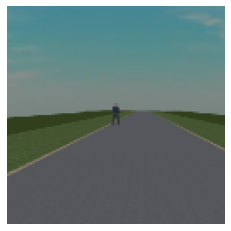

In [30]:
X = img_train[0].reshape(1, 128, 128, 3)
X_recon = od.ae(X)
plt.imshow(X.reshape(128, 128, 3))
plt.axis('off')
plt.show()

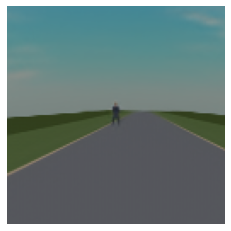

In [31]:
plt.imshow(X_recon.numpy().reshape(128, 128, 3))
plt.axis('off')
plt.show()